In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from lpaaj.constants import GRAPH_PATH, COLLATED_RESULTS_PATH as clp
from lpaaj.utils import families

In [2]:
datasets = ["newsroom", "summeval", "hanna"]
# read and average for each dataset
av_u, av_s = [], []
for dataset in datasets:
    probe_u = pd.read_json(
        f"{clp}/{dataset}/probe_u_results.jsonl",
        orient="records",
        lines=True,
    ).set_index("model")
    av_u.append(probe_u)
    probe_s = pd.read_json(
        f"{clp}/{dataset}/probe_s_results.jsonl",
        orient="records",
        lines=True,
    ).set_index("model")
    av_s.append(probe_s)
probe_u = [df.groupby("model").mean() for df in av_u]
probe_s = [df.groupby("model").mean() for df in av_s]
probe_u = sum(probe_u) / len(probe_u)
probe_s = sum(probe_s) / len(probe_s)

# load finetuning results
finetuning_results = pd.read_json(f"/workspace/PPairS_results/finetuning_results.jsonl", orient="records", lines=True)
finetuning_results["model"] = finetuning_results["model"].apply(lambda x: x.replace("-it", ""))
finetuning_results = finetuning_results[finetuning_results["category"] == "text_quality"].drop(columns=["category"]).reset_index(drop=True)
models = finetuning_results["model"].unique()
for model in models:
    subset = finetuning_results[(finetuning_results["model"] == model) & (finetuning_results["method"] == "full")]
    if len(subset) == 0:
        finetuning_results.loc[len(finetuning_results)] = ["full", model, float('nan')]
finetuning_results = finetuning_results.set_index("model")

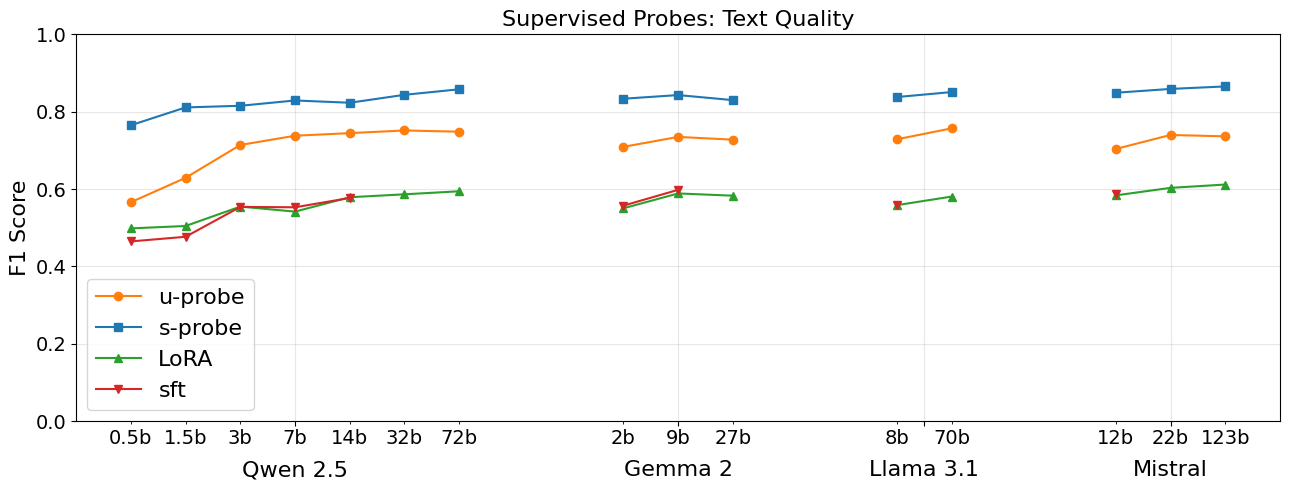

In [3]:
# create plot
fig, ax = plt.subplots(figsize=(13, 5))
x_pos, xticks, xlabels, minor_xticks, minor_xticklabels = 0, [], [], [], []
colours = {
    "u-probe": "#ff7f0e",
    "s-probe": "#1f77b4", 
    "lora": "#2ca02c",
    "sft": "#d62728"
}
family_full = {
    "mistral": "Mistral",
    "llama": "Llama 3.1",
    "qwen": "Qwen 2.5",
    "gemma": "Gemma 2"
}
for family, models in families.items():
    xcoords = range(x_pos, x_pos+len(models))
    # get scores for probes
    u_scores = probe_u.loc[models, "avg_f1"].values
    s_scores = probe_s.loc[models, "avg_f1"].values
    # plot lines
    ax.plot(xcoords, u_scores, marker="o", label="u-probe" if x_pos == 0 else "", color=colours["u-probe"])
    ax.plot(xcoords, s_scores, marker="s", label="s-probe" if x_pos == 0 else "", color=colours["s-probe"])
    # plot finetuning results
    lora_scores = finetuning_results[finetuning_results["method"] == "lora"].loc[models, "f1"].values
    ax.plot(xcoords, lora_scores, marker="^", label="LoRA" if x_pos == 0 else "", color=colours["lora"])
    full_scores = finetuning_results[finetuning_results["method"] == "full"].loc[models, "f1"].values
    ax.plot(xcoords, full_scores, marker="v", label="sft" if x_pos == 0 else "", color=colours["sft"])
    # labels
    xticks.append(x_pos + len(models)/2 - 0.5)
    xlabels.append(family_full[family])
    # add minor ticks for model sizes
    for i, model in enumerate(models):
        minor_xticks.append(x_pos + i)
        size = model.split('-')[-1]
        minor_xticklabels.append(size)
    # update xpos
    x_pos += len(models) + 2 # add gap between families
# customise plot
ax.xaxis.remove_overlapping_locs = False
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, fontsize=16, y=-0.075)
ax.set_xticks(minor_xticks, minor=True)
ax.set_xticklabels(minor_xticklabels, minor=True, fontsize=14)
ax.set_ylabel("F1 Score", fontsize=16)
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=16)
ax.tick_params(axis='y', labelsize=14)
ax.set_title("Supervised Probes: Text Quality", fontsize=16)
plt.tight_layout()
plt.savefig(f"{GRAPH_PATH}/supervised_probes_text_quality.png", dpi=400)
plt.show()